<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-3/dynamic-breakpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 动态断点 (Dynamic Breakpoints) - LangGraph 教程

## 什么是动态断点？

动态断点是 LangGraph 中一个强大的功能，允许在图的执行过程中**动态地**中断执行流程。与传统的静态断点不同，动态断点可以根据运行时的条件来决定是否中断，这为构建智能的人机交互系统提供了极大的灵活性。

# 动态断点 (Dynamic Breakpoints)

## 回顾：人机交互的动机

在前面的课程中，我们讨论了人机交互（Human-in-the-Loop）的三种主要动机：

### 1. 审批机制 (Approval)
- **功能**：中断智能体执行，向用户展示当前状态，允许用户决定是否接受某个操作
- **应用场景**：需要人工确认的重要决策，如金融交易、医疗诊断等

### 2. 调试功能 (Debugging)  
- **功能**：可以回退图的状态来重现或避免问题
- **应用场景**：开发调试、错误排查、性能优化

### 3. 状态编辑 (Editing)
- **功能**：允许修改图的状态
- **应用场景**：实时调整参数、修正错误、优化流程

## 传统断点 vs 动态断点

### 传统断点（静态断点）
- **设置时机**：在图编译时由开发者设置
- **特点**：固定的中断点，无法根据运行时条件改变
- **局限性**：缺乏灵活性，无法适应复杂的业务逻辑

### 动态断点（内部断点）
- **设置时机**：在节点内部根据条件动态触发
- **实现方式**：使用 `NodeInterrupt` 异常
- **优势**：
  1. **条件性中断**：基于开发者定义的逻辑条件
  2. **信息传递**：可以向用户传递中断原因
  3. **灵活控制**：根据运行时状态决定是否中断

## 本教程目标

我们将创建一个简单的图，演示如何根据输入长度动态触发中断。当输入超过5个字符时，图会抛出 `NodeInterrupt` 异常并暂停执行。

In [1]:
# 安装必要的依赖包
# 这个命令会安装 LangGraph 相关的核心包
%%capture --no-stderr
# %pip install --quiet -U langgraph langchain_openai langgraph_sdk
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32 langgraph_sdk==0.2.6

正在构建 LangGraph...
图构建完成！
图结构：START -> step_1 -> step_2 -> step_3 -> END
注意：step_2 包含动态断点逻辑

正在生成图的可视化...


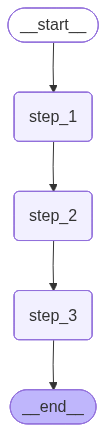

In [2]:
# 导入必要的库
from IPython.display import Image, display
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

# 定义图的状态结构
# TypedDict 用于定义状态的数据类型，确保类型安全
class State(TypedDict):
    input: str  # 输入字符串

# 第一步：简单的状态传递节点
def step_1(state: State) -> State:
    """
    第一步处理函数
    功能：接收状态并打印步骤信息，然后原样返回状态
    参数：state - 包含输入的状态字典
    返回：处理后的状态
    """
    print("---Step 1---")
    return state

# 第二步：包含动态断点的节点
def step_2(state: State) -> State:
    """
    第二步处理函数 - 演示动态断点
    功能：检查输入长度，如果超过5个字符则抛出 NodeInterrupt 异常
    参数：state - 包含输入的状态字典
    返回：处理后的状态（如果未中断）
    异常：NodeInterrupt - 当输入长度超过5个字符时抛出
    """
    # 动态断点逻辑：检查输入长度
    if len(state['input']) > 5:
        # 抛出 NodeInterrupt 异常，包含详细的错误信息
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state

# 第三步：最终处理节点
def step_3(state: State) -> State:
    """
    第三步处理函数
    功能：最终处理步骤，打印完成信息
    参数：state - 包含输入的状态字典
    返回：处理后的状态
    """
    print("---Step 3---")
    return state

# 构建图结构
print("正在构建 LangGraph...")
builder = StateGraph(State)

# 添加节点到图中
builder.add_node("step_1", step_1)  # 添加第一步节点
builder.add_node("step_2", step_2)  # 添加第二步节点（包含动态断点）
builder.add_node("step_3", step_3)  # 添加第三步节点

# 定义节点之间的连接关系
builder.add_edge(START, "step_1")      # 从开始到第一步
builder.add_edge("step_1", "step_2")   # 从第一步到第二步
builder.add_edge("step_2", "step_3")   # 从第二步到第三步
builder.add_edge("step_3", END)        # 从第三步到结束

# 设置内存检查点
# MemorySaver 用于保存图的状态，支持中断和恢复
memory = MemorySaver()

# 编译图并添加内存检查点
graph = builder.compile(checkpointer=memory)

print("图构建完成！")
print("图结构：START -> step_1 -> step_2 -> step_3 -> END")
print("注意：step_2 包含动态断点逻辑")

# 显示图的可视化结构
print("\n正在生成图的可视化...")
display(Image(graph.get_graph().draw_mermaid_png()))

## 测试动态断点功能

现在让我们用一个超过5个字符的输入来测试图，看看动态断点是如何工作的。

In [4]:
# 准备测试数据
# 使用一个超过5个字符的输入来触发动态断点
initial_input = {"input": "hello world"}  # 11个字符，会触发断点
thread_config = {"configurable": {"thread_id": "1"}}  # 线程配置，用于状态管理

print("开始执行图...")
print(f"输入内容: '{initial_input['input']}' (长度: {len(initial_input['input'])} 字符)")
print("预期结果: 在 step_2 处触发动态断点")
print("-" * 50)

# 运行图直到第一次中断
# stream_mode="values" 表示只返回状态值，不返回其他元数据
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(f"状态更新: {event}")

print("-" * 50)
print("图执行被中断！")

开始执行图...
输入内容: 'hello world' (长度: 11 字符)
预期结果: 在 step_2 处触发动态断点
--------------------------------------------------
状态更新: {'input': 'hello world'}
---Step 1---
状态更新: {'input': 'hello world'}
--------------------------------------------------
图执行被中断！


/tmp/ipython-input-3069364372.py:36: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


## 检查中断后的图状态

当图被中断后，我们可以检查当前的状态，看看下一个要执行的节点是什么。


In [5]:
# 获取当前图的状态
state = graph.get_state(thread_config)

print("当前图状态信息:")
print(f"下一个要执行的节点: {state.next}")
print(f"当前状态值: {state.values}")
print(f"是否有中断: {len(state.tasks) > 0 and any(task.interrupts for task in state.tasks)}")

# 检查中断详情
if state.tasks:
    for task in state.tasks:
        if task.interrupts:
            print(f"中断信息: {task.interrupts}")

当前图状态信息:
下一个要执行的节点: ('step_2',)
当前状态值: {'input': 'hello world'}
是否有中断: True
中断信息: (Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),)


## 查看中断详情

我们可以看到中断信息被记录在状态中，这包含了中断的原因和上下文信息。

In [6]:
# 查看任务详情，包括中断信息
print("任务详情:")
for i, task in enumerate(state.tasks):
    print(f"任务 {i+1}:")
    print(f"  - 任务ID: {task.id}")
    print(f"  - 节点名称: {task.name}")
    print(f"  - 错误信息: {task.error}")
    print(f"  - 中断信息: {task.interrupts}")
    print(f"  - 状态: {task.state}")
    print()

任务详情:
任务 1:
  - 任务ID: 2298311f-c3a5-0ecc-da6c-86c45f7651cd
  - 节点名称: step_2
  - 错误信息: None
  - 中断信息: (Interrupt(value='Received input that is longer than 5 characters: hello world', id='placeholder-id'),)
  - 状态: None



## 尝试恢复图执行

我们可以尝试从断点处恢复图的执行。但是，如果状态没有改变，图会重新执行同一个节点，导致无限循环！

In [7]:
# 尝试恢复图执行（不改变状态）
print("尝试恢复图执行（不改变状态）...")
print("注意：这会导致重新执行 step_2，再次触发中断！")
print("-" * 50)

for event in graph.stream(None, thread_config, stream_mode="values"):
    print(f"状态更新: {event}")

print("-" * 50)
print("图再次被中断！")

尝试恢复图执行（不改变状态）...
注意：这会导致重新执行 step_2，再次触发中断！
--------------------------------------------------
状态更新: {'input': 'hello world'}
--------------------------------------------------
图再次被中断！


/tmp/ipython-input-3069364372.py:36: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [ ]:
# 再次检查状态，确认仍在 step_2
state = graph.get_state(thread_config)
print(f"当前状态: 仍在 {state.next} 节点")
print("这证明了如果不改变状态，图会一直重复执行同一个节点！")

('step_2',)


## 修改状态以解决中断

现在我们需要修改状态来解决中断问题。我们可以将输入改为5个字符或更少，这样就不会触发动态断点了。

In [8]:
# 更新状态：将输入改为短字符串，避免触发断点
print("正在更新状态...")
print("原输入: 'hello world' (11字符)")
print("新输入: 'hi' (2字符)")

# 使用 update_state 方法修改图的状态
result = graph.update_state(
    thread_config,
    {"input": "hi"},  # 新的输入，只有2个字符
)

print(f"状态更新结果: {result}")
print("现在可以继续执行图了！")

正在更新状态...
原输入: 'hello world' (11字符)
新输入: 'hi' (2字符)
状态更新结果: {'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb36-56e6-644a-8005-5309408c3550'}}
现在可以继续执行图了！


In [9]:
# 继续执行图，现在应该能正常完成
print("继续执行图...")
print("预期结果: 所有步骤都能正常执行，不会触发中断")
print("-" * 50)

for event in graph.stream(None, thread_config, stream_mode="values"):
    print(f"状态更新: {event}")

print("-" * 50)
print("图执行完成！")

继续执行图...
预期结果: 所有步骤都能正常执行，不会触发中断
--------------------------------------------------
状态更新: {'input': 'hi'}
---Step 2---
状态更新: {'input': 'hi'}
---Step 3---
状态更新: {'input': 'hi'}
--------------------------------------------------
图执行完成！


## 使用 LangGraph Studio 进行可视化调试

### 启动本地开发服务器

**⚠️ 重要说明**

自视频录制以来，我们已经更新了 Studio，现在可以在本地运行并在浏览器中打开。这是在本地运行 Studio 的首选方式（而不是使用视频中显示的桌面应用程序）。

要启动本地开发服务器，请在此模块的 `/studio` 目录中运行以下命令：

```bash
langgraph dev
```

您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中打开 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`

### Studio 的优势

1. **可视化调试**：可以直观地看到图的执行流程
2. **状态检查**：实时查看每个节点的状态变化
3. **交互式操作**：可以手动修改状态并继续执行
4. **断点管理**：方便地管理各种类型的断点

In [ ]:
# 检查是否在 Google Colab 环境中运行
# LangGraph Studio 目前不支持 Google Colab
if 'google.colab' in str(get_ipython()):
    raise Exception("很抱歉，LangGraph Studio 目前不支持在 Google Colab 中运行")

## 通过 SDK 连接到 Studio

现在我们将通过 LangGraph SDK 连接到本地开发服务器，演示如何在 Studio 环境中使用动态断点。

In [ ]:
# 导入 LangGraph SDK
from langgraph_sdk import get_client

# 连接到本地开发服务器
URL = "http://127.0.0.1:2024"  # 本地开发服务器的地址
print(f"正在连接到 LangGraph Studio: {URL}")

try:
    client = get_client(url=URL)
    print("✅ 连接成功！")

    # 搜索所有可用的图
    print("正在搜索可用的图...")
    assistants = await client.assistants.search()
    print(f"找到 {len(assistants)} 个可用的图")

    # 显示可用的图
    for i, assistant in enumerate(assistants):
        print(f"  {i+1}. {assistant['assistant_id']}")

except Exception as e:
    print(f"❌ 连接失败: {e}")
    print("请确保 LangGraph Studio 正在运行 (langgraph dev)")

In [ ]:
# 创建一个新的线程来执行图
print("创建新的执行线程...")
thread = await client.threads.create()
print(f"线程ID: {thread['thread_id']}")

# 准备测试输入（会触发动态断点）
input_dict = {"input": "hello world"}
print(f"输入数据: {input_dict}")

print("\n开始执行图...")
print("预期结果: 在 step_2 处触发动态断点")
print("-" * 60)

# 使用 SDK 执行图
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",  # 使用预定义的动态断点图
    input=input_dict,
    stream_mode="values",):

    print(f"收到事件类型: {chunk.event}")
    print(f"事件数据: {chunk.data}")
    print("\n" + "="*40 + "\n")

print("图执行被中断！")

Receiving new event of type: metadata...
{'run_id': '1ef6a43a-1b04-64d0-9a79-1caff72c8a89'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [ ]:
# 获取当前线程的状态
print("获取当前线程状态...")
current_state = await client.threads.get_state(thread['thread_id'])
print("状态获取成功！")

In [ ]:
# 查看下一个要执行的节点
print("当前状态信息:")
print(f"下一个要执行的节点: {current_state['next']}")
print(f"当前状态值: {current_state['values']}")
print(f"是否有中断: {len(current_state['tasks']) > 0 and any(task.get('interrupts') for task in current_state['tasks'])}")

['step_2']

In [ ]:
# 更新线程状态以解决中断
print("正在更新线程状态...")
print("原输入: 'hello world' (11字符)")
print("新输入: 'hi!' (3字符)")

# 使用 SDK 更新状态
result = await client.threads.update_state(thread['thread_id'], {"input": "hi!"})
print(f"状态更新结果: {result}")
print("现在可以继续执行图了！")

{'configurable': {'thread_id': 'ea8c2912-987e-49d9-b890-6e81d46065f9',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'},
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968'}

In [ ]:
# 继续执行图，现在应该能正常完成
print("继续执行图...")
print("预期结果: 所有步骤都能正常执行，不会触发中断")
print("-" * 60)

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,  # 使用 None 表示继续执行，不提供新输入
    stream_mode="values",):

    print(f"收到事件类型: {chunk.event}")
    print(f"事件数据: {chunk.data}")
    print("\n" + "="*40 + "\n")

print("图执行完成！")

Receiving new event of type: metadata...
{'run_id': '1ef64c33-fb34-6eaf-8b59-1d85c5b8acc9'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [ ]:
# 检查最终状态
print("检查最终状态...")
current_state = await client.threads.get_state(thread['thread_id'])

print("最终状态信息:")
print(f"下一个要执行的节点: {current_state['next']}")
print(f"当前状态值: {current_state['values']}")
print(f"任务数量: {len(current_state['tasks'])}")
print(f"是否有中断: {len(current_state['tasks']) > 0 and any(task.get('interrupts') for task in current_state['tasks'])}")

if not current_state['next']:
    print("✅ 图已成功完成执行！")
else:
    print(f"⚠️ 图仍在等待执行: {current_state['next']}")

{'values': {'input': 'hi!'},
 'next': ['step_2'],
 'tasks': [{'id': '858e41b2-6501-585c-9bca-55c1e729ef91',
   'name': 'step_2',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 2,
  'source': 'update',
  'writes': {'step_1': {'input': 'hi!'}},
  'parents': {},
  'graph_id': 'dynamic_breakpoints'},
 'created_at': '2024-09-03T22:27:05.707260+00:00',
 'checkpoint_id': '1ef6a43a-64b2-6e85-8002-3cf4f2873968',
 'parent_checkpoint_id': '1ef6a43a-1cb8-6c3d-8001-7b11d0d34f00'}

## 总结

### 动态断点的核心概念

1. **条件性中断**：根据运行时条件决定是否中断
2. **信息传递**：通过 `NodeInterrupt` 传递中断原因
3. **状态管理**：需要修改状态才能解决中断问题

### 关键学习点

1. **NodeInterrupt 异常**：用于在节点内部触发动态中断
2. **状态更新**：使用 `update_state` 方法修改图状态
3. **中断恢复**：修改状态后可以继续执行图
4. **Studio 集成**：通过 SDK 在 Studio 环境中使用动态断点

### 实际应用场景

- **内容审核**：当检测到敏感内容时中断，等待人工审核
- **质量控制**：当输出质量不达标时中断，要求重新生成
- **用户确认**：当需要用户确认重要操作时中断
- **错误处理**：当检测到异常情况时中断，等待处理

### 最佳实践

1. **明确中断条件**：确保中断条件清晰且必要
2. **提供有用信息**：在 `NodeInterrupt` 中包含足够的上下文信息
3. **状态设计**：确保状态可以被合理修改以解决中断
4. **用户体验**：考虑用户如何理解和处理中断情况
